# Project - 4 - Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Loading data into a DataFrame
df_ab = pd.read_csv('ab_data.csv')

# Displaying DataFrame
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Use the below cell to find the number of rows in the dataset.

In [4]:
# Determining the number of rows in the dataset
print("The number of rows is: ", df_ab.shape[0])

The number of rows is:  294478


c. The number of unique users in the dataset.

In [5]:
# Determining the number of unique users in the dataset
print("The number of unique users is: ", df_ab['user_id'].nunique())

The number of unique users is:  290584


d. The proportion of users converted.

In [6]:
# Calculating the proportion of users converted
print("The proportion of users converted is: ", df_ab['converted'].mean())

The proportion of users converted is:  0.11965919355605512


e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# Number of treatment group users landing on old page
treat_old_pg = len(df_ab.query("group == 'treatment' and landing_page == 'old_page'"))

# Number of control group users landing on new page
ctrl_new_pg = len(df_ab.query("group == 'control' and landing_page == 'new_page'"))

# Total number of times new page and treament don't line up
misalign = treat_old_pg + ctrl_new_pg

# Printing results
print("The number of treatment group users landing on old_page is: {}".format(treat_old_pg))
print("The number of control group users landing on new_page is: {}".format(ctrl_new_pg))
print("The number of times new_page and treatment don't line up is: {}".format(misalign))

The number of treatment group users landing on old_page is: 1965
The number of control group users landing on new_page is: 1928
The number of times new_page and treatment don't line up is: 3893


f. Do any of the rows have missing values?

In [8]:
# Determining the number of missing values
df_ab.isnull().sum().sum()

0

**We can deduce that there are no missing values in the dataset**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Dropping rows for misaligned treatment group users
df_ab.drop(df_ab.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

# Dropping rows for misaligned control group users 
df_ab.drop(df_ab.query("group =='control' and landing_page == 'new_page'").index, inplace=True)

In [10]:
# Verifying changes made to the original DataFrame
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
# Saving cleaned dataset to a new .csv file
df_ab.to_csv('ab_clean.csv', index=False)

In [12]:
# Loading cleaned dataset to new DataFrame to be used for the rest of the analysis
df2 = pd.read_csv('ab_clean.csv')

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [14]:
# Number of unique users in the cleaned dataset
print("Number of unique users: ", df2['user_id'].nunique())

Number of unique users:  290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# Identifying repeated user_id in df2
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
# Displaying row information for the repeat user_id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# Dropping duplicate suer_id
df2.drop(labels=1876, axis=0, inplace=True)

In [18]:
# Verifying the drop operation
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
# Calculating the probability of an individual converting regardless of the page
print("Probability of individual converting, regardless of the page: ", 
      df2['converted'].mean())

Probability of individual converting, regardless of the page:  0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# Calculating the probability of an individual converting from the control group
print("Probability of individual converting from the control group: ", 
      df2.query("group =='control'")['converted'].mean())

Probability of individual converting from the control group:  0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
# Calculating the probability of an individual converting from the treament group
print("Probability of individual converting from the treatment group: ", 
      df2.query("group == 'treatment'")['converted'].mean())

Probability of individual converting from the treatment group:  0.11880806551510564


d. What is the probability that an individual received the new page?

In [22]:
# Calculating the probability of an individual receiving a new page
print("Probability of an individual receiving the new page: ", 
      len(df2[df2['landing_page'] == 'new_page']) / len(df2))

Probability of an individual receiving the new page:  0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Based on the results of our calculations above, it is observed that the treatment group's conversion rate of approxiamtely **(0.1188)** is lower than the control group's conversion rate of approximately **(0.1204)**.

The difference between the two, however, is miniscule to be considered significant. We must also consider that various influencing factors, such as **change aversion** and **test span durations** are not accounted for.

In order to conclusively state that one page design is superior to the other, we must define and test our hypothesis, in addition to calculating the associated **p-values** for both old and new pages.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### Hypotheses:

- **Null Hypothesis:**
The null hypothesis is that the difference between the conversion rate of users of the new page and the old page is less than or equal to zero. Meaning, the new page's conversion rate is the same or lower than the old page.

$$ H_0: p_{new} - p_{old} \leq 0$$

- **Alternative-Hypothesis:**
The alternative hypothesis is that the difference between the conversion rate of users of the new page and the old page is greater than zero. Meaning, the new page has a higher conversion rate.
$$ H_1: p_{new} - p_{old} \gt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
# Calculating the convert rate for p_new under the null
# Assuming p_old = p_new
p_new = df2['converted'].mean()
print("Conversion rate for p_new, under the null: ", p_new)

Conversion rate for p_new, under the null:  0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
# Calculating the convert rate for p_old under the null
# Assuming p_old = p_new
p_old = df2['converted'].mean()
print("Conversion rate for p_old under the null: ", p_old)

Conversion rate for p_old under the null:  0.11959708724499628


c. What is $n_{new}$?

In [25]:
# Determining n_new
n_new = len(df2.query("group == 'treatment'"))
print("Number of tests with the new page: ", n_new)

Number of tests with the new page:  145310


d. What is $n_{old}$?

In [26]:
# Determining n_old
n_old = len(df2.query("group == 'control'"))
print("Number of tests with the old page: ", n_old)

Number of tests with the old page:  145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# Simulating n_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([1, 0], size = n_new, p=[p_new, (1-p_new)])
print("Simulated conversion for new page: ", new_page_converted.mean())

Simulated conversion for new page:  0.12054917073842131


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# Simulating n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([1, 0], size = n_old, p=[p_old, (1-p_old)])
print("Simulated conversion for old page: ", old_page_converted.mean())

Simulated conversion for old page:  0.12028993488167188


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# Finding p_new - p_old for the simulated values
p_diff = new_page_converted.mean() - old_page_converted.mean()
print("Difference in p for simulated values under the null hypothesis: ", p_diff)

Difference in p for simulated values under the null hypothesis:  0.00025923585674943184


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [56]:
# Simulating 10,000 p_new - p_old values and storing in a numpy array called p_diffs

# Post Review : Removing the for loop and utilizing numpy for increased efficiency
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

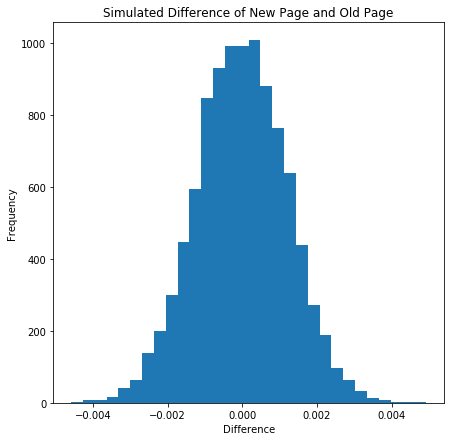

In [57]:
# Plotting histogram for p_diffs
plt.figure(figsize=(7,7))
plt.hist(p_diffs, bins=30)
plt.title('Simulated Difference of New Page and Old Page')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [58]:
# Calculating the actual difference from the original dataset.
org_old = df_ab.query("group == 'control'")['converted'].mean()
org_new = df_ab.query("group == 'treatment'")['converted'].mean()
act_diffs = org_new - org_old

print("Actual difference from the observed dataset: ", act_diffs)

Actual difference from the observed dataset:  -0.0015790565976871451


In [59]:
# Converting p_diffs to a numpy array
p_diffs = np.array(p_diffs)
p_diffs

array([ 1.11291130e-03, -1.39927849e-04, -5.25263073e-04, ...,
       -2.08546709e-04, -9.13780900e-05, -2.15478003e-04])

In [60]:
# Proportion of p_diffs greater than the actual difference in original dataset
print("Proportion of p_diffs greater than actual difference: ", (p_diffs > act_diffs).mean())

Proportion of p_diffs greater than actual difference:  0.9021


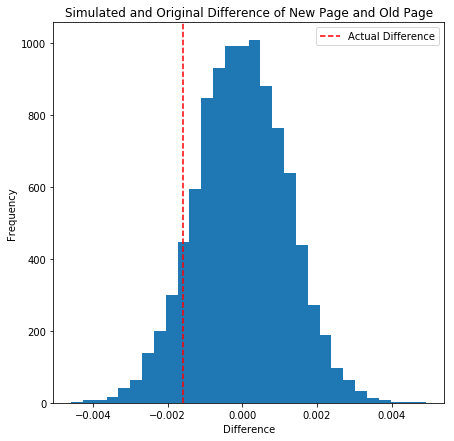

In [61]:
# Plotting the above calculations
plt.figure(figsize=(7,7))
plt.hist(p_diffs, bins=30)
plt.title('Simulated and Original Difference of New Page and Old Page')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.axvline(x=(act_diffs), c='r', linestyle='dashed', label='Actual Difference')
plt.legend()
plt.show();

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANSWER.**

- From the simulations above, we can observe that the probability of conversion of a new page is lower than both the mean and the conversion rates for the old page.

- If the null hypothesis held for our sample then the proportion greater than the actual difference would have been **0.5**. Our calculations show that approximately **90%** of the simulated sample lies above the real difference.

- This suggests that the new page does is not significantly better than the old page, in fact, it may even be inferior.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [62]:
import statsmodels.api as sm

#Using built-ins to acheive the aforementioned results
convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

# Printing the said values for verification
print("Conversions for the old page: {}\n"
      "Conversions for the new page: {}\n"
      "Tests for the old page: {}\n"
      "Tests for the new page: {}\n".format(convert_old, convert_new, n_old, n_new))

Conversions for the old page: 17489
Conversions for the new page: 17264
Tests for the old page: 145274
Tests for the new page: 145310



m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [63]:
# Correction made following review
z_score, p_value = sm.stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old, n_new], alternative='smaller')
print("z-score: {}\np-value: {}".format(z_score, p_value))

z-score: 1.3109241984234394
p-value: 0.9050583127590245


In [64]:
# Correction made following review
# Importing scipy and 
from scipy.stats import norm

# Significance of the z-score
print(norm.cdf(z_score))
# Critical value at 95% confidence for one sided test
print(norm.ppf(1 - (0.05)))

0.9050583127590245
1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**ANSWER**

- Following the `stats.proportions_ztest` it is observed that our z-score, with a value of **1.3109241**, is less than the critical value **1.6448536**. Thus we fail to reject the null hypothesis.

- Given the above definition, it would seem that the differences between simulated difference and the actual difference is 1.31 standard deviations. The p-value indicates the probability that this result is due to random chance, and thus the evidence is not significant enough to reject the null hypothesis.

- This is **consistent** with our findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**ANSWER:** Since each row is either a conversion or isn't - in other words, a 'yes' or 'no' scenario - we will use **Logistic Regression**.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [52]:
# statsmodels.api has already been imported
# Creating intercept and dummy variable columns

df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])[['treatment']]
df2.head(4)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [53]:
# Instantiating and fitting our regression model
reg_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = reg_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [54]:
# Summary of our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:08:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**ANSWER**

- The p-value associated with ab_page is **0.190**.

- The reason for the difference in values is that in Part II, we conducted a one-tailed test in which we tested whether one page was better than the other. Alternatively, in Part III we used regression testing which is a two-tailed test, dealing with the statistical difference of proportions.

- The reason for the variation in results is due to the inclusion of an intercept in our model. Thus, the second value has a higher accuracy.

- The value still indicates that we **have failed to reject** our null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**ANSWER**

- Certain additional factors, adding relevant details of test and control group segmentation - additional data such as age, level of professional development, industry etc.  would add a higher amount of detail to our analysis.

- However, it must be noted that there are certain disadvantages to adding too many features into our analysis. Simpson's paradox is a notable example.

- While conducting regression analysis, we would want to list features which have higher impacts on our outcomes. However, the primary 'down-side' to the regression analysis is that listing all relevant and influential factors is extremely difficult. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [55]:
# Creating a DataFrame for countries and joining with df2

countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(4)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0


In [56]:
# Determining value counts for different countries in df_new
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [57]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])[['US', 'UK', 'CA']]
df_new.head(4)

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0


In [58]:
# Creating a model for countries and fitting
log_country = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results_2 = log_country.fit()
results_2.summary()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               1.521e-05
Time:                        11:10:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [59]:
1 / (np.exp(results_2.params))

intercept    7.671651
US           0.960018
UK           0.950546
dtype: float64

**NOTE:** It appears that country does have a marginal effect on conversion rates, though this is not high enough to be considered statistically significant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
### Fit Your Linear Model And Obtain the Results, intercept has already been created
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results_3 = log_mod.fit()
results_3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        11:10:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [61]:
# Calculations for interpreting results
np.exp(results_3.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

In [62]:
1 / (np.exp(results_3.params)) # 1/_ wasn't working for some reason

intercept    7.614303
ab_page      1.015056
US           0.960062
UK           0.950621
dtype: float64

#### Takeaways from Regression Analysis:

It can be observed in the logistic regression model above that when adding additional factors like **country** and **ab_page** together it seems that the p-values for all features has increased. Additionally, the z-score for the intercept changes its value dramatically.

<a id='conclusions'></a>
## Conclusions

During the preliminary sections of the analysis there appears to be a difference between the conversion rates of new and old pages, though this isn't significant enough to reject our null hypothesis. From the histogram shown in section-2, it seems that the new page underperforms when compared to the old page.

It was also found that page-performance was not significantly dependent on countries, where it wa observed that conversion rates were roughly the same in the United Kingdom and the United States. As for the test conditions, users had an approximate chance of 50% to receive the new and old pages and the sample size of the initial dataframe is sufficient. However, as mentioned earlier, an analysis such as this would benefit from additional user segmentation data.

Thus, it is recommended that the e-commerce company in question spend their fiscal and human resources on trying to improve their test website UI / UX before attempting another A/B test.


## Sources:

1. [Two Sample Proportion Hypothesis Testing with Statsmodels](http://knowledgetack.com/python/statsmodels/proportions_ztest/)


2. [Random Sampling Using Numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html)


3. [Udacity - Data Analyst Nanodegree - Term 1 - Section 4 - Practical Statistics](https://www.udacity.com/course/data-analyst-nanodegree--nd002)


4. [Statistics How To - Online Quick Reference](https://statisticshowto.com/)


5. [What is a p-value and how do you calculate it? - Pursuing Data Blog:](https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value)


6. Pandas text book: McKinney, W. (2017). Python for data analysis: Data wrangling with pandas, NumPy, and IPython. Sebastopol, CA: OReilly.
